In [1]:
import bpy

# Path to your .blend file
blend_file_path = "asset_networkX.blend"

# Open the .blend file
bpy.ops.wm.open_mainfile(filepath=blend_file_path)

Read blend: "/Users/jan-hendrik/projects/ipyblender-gui/asset_networkX.blend"


{'FINISHED'}

In [21]:
import networkx as nx


import itertools
import matplotlib.pyplot as plt
import networkx as nx


G = nx.tutte_graph()
scale = 6
node_positions = nx.spring_layout(G, dim=3)
edges = list(G.edges)

import bpy

# Function to delete all objects in a collection
def clear_collection(collection):
    for obj in collection.objects:
        bpy.data.objects.remove(obj, do_unlink=True)

# Function to get or create a collection
def get_or_create_collection(name, parent=None):
    collection = bpy.data.collections.get(name)
    if not collection:
        collection = bpy.data.collections.new(name)
        if parent:
            parent.children.link(collection)
    else:
        clear_collection(collection)
    return collection


# Get or create the "Graph" collection and its children "Nodes" and "Edges"
graph_collection = get_or_create_collection("Graph", bpy.context.scene.collection)
edges_collection = get_or_create_collection("Edges", graph_collection)
nodes_collection = get_or_create_collection("Nodes", graph_collection)

# Clear the Nodes collection
clear_collection(nodes_collection)

# Create spheres at the points and add them to the Nodes collection
spheres = {}
for key, coords in node_positions.items():
    bpy.ops.mesh.primitive_uv_sphere_add(location=(coords[0]*scale, coords[1]*scale, coords[2]*scale), radius=0.1)
    sphere = bpy.context.object
    sphere.name = f"my_pointXS{key}"
    nodes_collection.objects.link(sphere)
    bpy.context.collection.objects.unlink(sphere)
    spheres[key] = sphere

# Add "material1" to all the spheres
material = bpy.data.materials.get("Material1")

for sphere in spheres.values():
    if len(sphere.data.materials):
        sphere.data.materials[0] = material
    else:
        sphere.data.materials.append(material)

# Create a copy of the node group to use for each edge
node_group = bpy.data.node_groups.get("my_connector")

# Create plane objects at the center of each edge and add geometry nodes modifier
for i, (edge1, edge2) in enumerate(edges):
    bpy.ops.mesh.primitive_plane_add(size=0.2)  
    plane = bpy.context.object
    plane.name = f"edge{i+1}"
    edges_collection.objects.link(plane)
    bpy.context.collection.objects.unlink(plane)
    
    # Duplicate the geometry nodes modifier node group for each edge
    new_node_group = node_group.copy()
    new_node_group.name = f"my_connector{i+1}"
    modifier = plane.modifiers.new(name="my_connector", type='NODES')
    modifier.node_group = new_node_group
    
    # Collect Object Info nodes into a list
    object_info_nodes = [node for node in new_node_group.nodes if node.type == 'OBJECT_INFO']
    
    # Set the Object Info nodes to point to the corresponding spheres
    sphere1 = bpy.data.objects.get(f"my_pointXS{edge1}")
    sphere2 = bpy.data.objects.get(f"my_pointXS{edge2}")
    
    object_info_nodes[0].inputs[0].default_value = sphere1
    object_info_nodes[1].inputs[0].default_value = sphere2
    
    # Set material to Material1 in the Set Material node
    material1 = bpy.data.materials.get("Material1")
    for node in new_node_group.nodes:
        if node.type == 'SET_MATERIAL':
            node.inputs['Material'].default_value = material1

Saved: '/tmp/test.png'
Time: 00:00.15 (Saving: 00:00.00)



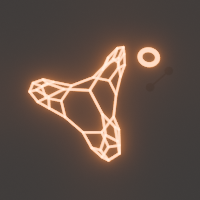

In [31]:
import bpy
from IPython.display import display, Image

# Set the camera location and rotation
camera = bpy.data.objects['Camera']
camera.location = (11, 3, 25)
camera.rotation_euler = (0.42, 0.0, 1.75)

# Set the render resolution
bpy.context.scene.render.resolution_x = 200
bpy.context.scene.render.resolution_y = 200

# Render the image and save it
path = "/tmp/test.png"
bpy.context.scene.render.filepath = path
bpy.ops.render.render(write_still=True)

# Display the rendered image
display(Image(filename=path))